In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Graph Neural Network and GCN

Sources:
- https://arshren.medium.com/different-graph-neural-network-implementation-using-pytorch-geometric-23f5bf2f3e9f 
- https://github.com/chifish/SyntacticGCN/blob/main/gcn.py 

In [ ]:
!pip install torch_geometric
!pip install torch_sparse
!pip install torch_scatter

In [ ]:
#Import libraries for different Graph Neural Network

import numpy as np
import pandas as pd
import os
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric
from torch.nn import Parameter
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import urllib.request
import tarfile
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

In [ ]:
# Load the PubMMed dataset
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

Processing...
Done!


In [ ]:
# view the dataset details
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}') # data.x --> each data point has 500 features and a label
print(f'Number of classes: {dataset.num_classes}') # data.y

# --> you can do the same with your bias dataset using GloVe average embeddings, or features from paper 104

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


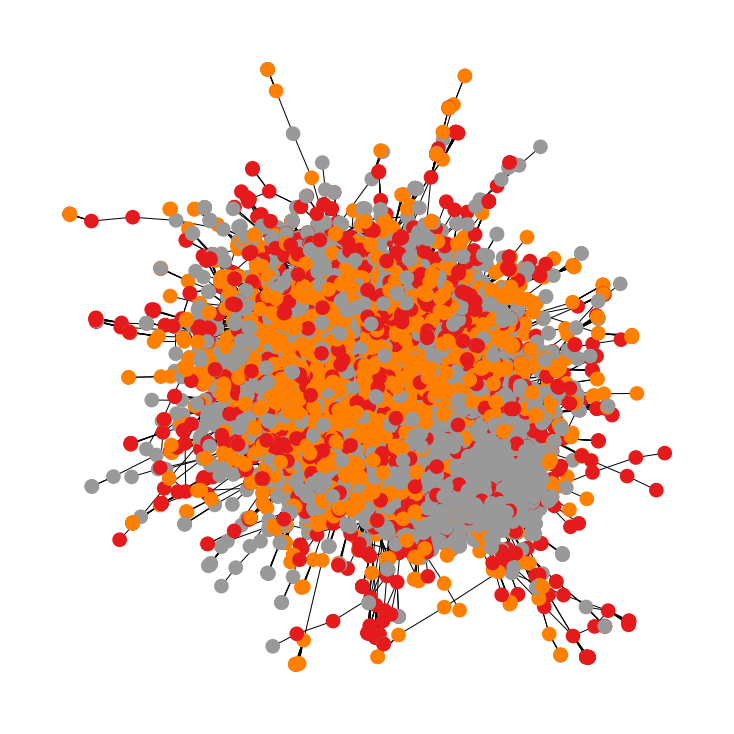

In [ ]:
#Visualize the graph using networkx
plt.figure(figsize=(10, 10))
pubmed = torch_geometric.data.Data(x=data.x[:500], edge_index=data.edge_index[:500])
g = torch_geometric.utils.to_networkx(pubmed, to_undirected=True)
pubmedGraph = to_networkx(pubmed)
node_labels = data.y[list(pubmedGraph.nodes)].numpy()
nx.draw(g, cmap=plt.get_cmap('Set1'),node_color = node_labels,node_size=75,linewidths=6)

In [ ]:
#set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Create batches with neighbor sampling
#A NeighborLoader is a data loader that performs neighbor sampling for GNN's
#Allows for mini-batch training of GNNs on large-scale graphs where full-batch training is not feasible.
#num_neighbors denotes how many neighbors are sampled for each node in each iteration.
#https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

In [ ]:
'''
Graph Convolutional Network
GCN takes graphs as an input and applies convolution operations over the graph
'''
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)
    def forward(self, x, edge_index):
        # x: Node feature matrix 
        # edge_index: Graph connectivity matrix 
        #x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x, F.log_softmax(x, dim=1)

In [ ]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


In [ ]:
def train(model, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        
        _, out = model(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

In [ ]:
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
# Create GCN
gcn = GCN().to(device)
print(gcn)

# Train GCN
train(gcn, dataset, 200)

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)
Epoch   0 | Train Loss: 1.109 | Train Acc:  27.32% | Val Loss: 1.11 | Val Acc: 28.75%
Epoch  10 | Train Loss: 0.873 | Train Acc:  85.36% | Val Loss: 0.91 | Val Acc: 69.11%
Epoch  20 | Train Loss: 0.641 | Train Acc:  85.26% | Val Loss: 0.64 | Val Acc: 76.67%
Epoch  30 | Train Loss: 0.403 | Train Acc:  96.69% | Val Loss: 0.66 | Val Acc: 60.95%
Epoch  40 | Train Loss: 0.296 | Train Acc:  96.61% | Val Loss: 0.45 | Val Acc: 80.39%
Epoch  50 | Train Loss: 0.226 | Train Acc:  97.92% | Val Loss: 0.53 | Val Acc: 69.05%
Epoch  60 | Train Loss: 0.168 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 72.43%
Epoch  70 | Train Loss: 0.215 | Train Acc:  95.83% | Val Loss: 0.47 | Val Acc: 76.74%
Epoch  80 | Train Loss: 0.175 | Train Acc:  94.36% | Val Loss: 0.53 | Val Acc: 82.29%
Epoch  90 | Train Loss: 0.142 | Train Acc:  97.14% | Val Loss: 0.41 | Val Acc: 85.35%
Epoch 100 | Train Loss: 0.127 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc: 

In [ ]:
# Test GCN
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')


GCN test accuracy: 78.70%



# GCN Syntactically Aware Encoding

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time

class GraphConvolution(nn.Module):
    """
    syntactic GCN network, proposed in https://www.aclweb.org/anthology/D17-1159/
    """

    def __init__(self, in_features, out_features, num_labels=44, dropout=0.2, gating=True, in_arcs=True, out_arcs=True, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_labels = num_labels
        self.in_arcs = in_arcs              
        self.out_arcs = out_arcs
        self.gating = gating
        self.dropout = nn.Dropout(p=dropout)

        self.w_in = nn.ParameterList([nn.Parameter(torch.FloatTensor(in_features, out_features)) for i in range(num_labels)])
        self.w_out = nn.ParameterList([nn.Parameter(torch.FloatTensor(in_features, out_features)) for i in range(num_labels)])
        self.w_loop = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.b_in = nn.ParameterList([nn.Parameter(torch.FloatTensor(out_features)) for i in range(num_labels)])
        self.b_out = nn.ParameterList([nn.Parameter(torch.FloatTensor(out_features)) for i in range(num_labels)])
        self.b_loop = nn.Parameter(torch.FloatTensor(out_features))

        if self.gating:
            self.w_in_g = nn.ParameterList([nn.Parameter(torch.FloatTensor(in_features, 1)) for i in range(num_labels)])
            self.w_out_g = nn.ParameterList([nn.Parameter(torch.FloatTensor(in_features, 1)) for i in range(num_labels)])
            self.w_loop_g = nn.Parameter(torch.FloatTensor(in_features, 1))
            self.b_in_g = nn.ParameterList([nn.Parameter(torch.FloatTensor(1)) for i in range(num_labels)])
            self.b_out_g = nn.ParameterList([nn.Parameter(torch.FloatTensor(1)) for i in range(num_labels)])
            self.b_loop_g = nn.Parameter(torch.FloatTensor(1))

    def forward(self, gcn_inp, adj_mat):

        adj_mat = self.dropout(adj_mat)
        h = torch.matmul(gcn_inp, self.w_loop) #(bs, len, hidden_size) x (hidden_size, hidden_size)
        h = h + self.b_loop

        if self.gating:
            loop_gates = torch.sigmoid(torch.matmul(gcn_inp, self.w_loop_g) + self.b_loop_g)
            h = h * loop_gates

        act_sum = h

        for lbl in range(self.num_labels):
            if self.in_arcs:
                inp_in     = torch.matmul(gcn_inp, self.w_in[lbl]) + self.b_in[lbl] #inp_in: (bs, len, hidden_size)
                if self.gating:
                    inp_in_g = torch.matmul(gcn_inp, self.w_in_g[lbl]) + self.b_in_g[lbl]
                    inp_in = inp_in * torch.sigmoid(inp_in_g)

                adj_matrix = adj_mat[lbl].permute(0,2,1) #(bs, len, len)
                in_act = torch.bmm(adj_matrix, inp_in)  #aggregate  (bs, len, hidden_size)

            if self.out_arcs:
                inp_out    = torch.matmul(gcn_inp, self.w_out[lbl]) + self.b_out[lbl]
                if self.gating:
                    inp_out_g = torch.matmul(gcn_inp, self.w_out_g[lbl]) + self.b_out_g[lbl]
                    inp_out = inp_out * torch.sigmoid(inp_out_g)

                adj_matrix = adj_mat[lbl]
                out_act = torch.bmm(adj_matrix, inp_out)

            act_sum += in_act + out_act

        return F.relu(act_sum)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

# Text-Based GCN for Text Classification
source: https://towardsdatascience.com/text-based-graph-convolutional-network-for-semi-supervised-bible-book-classification-c71f6f61ff0f 

## Generate Train/Test datasets

In [ ]:
import os
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np
import networkx as nx
from collections import OrderedDict
from itertools import combinations
from string import punctuation
import math
from tqdm import tqdm
import logging
import torch.nn as nn

data_path = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/GCN data/"  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def nCr(n,r):
    f = math.factorial
    return int(f(n)/(f(r)*f(n-r)))

def dummy_fun(doc):
    return doc

In [ ]:
def load_pickle(filename):
    completeName = os.path.join("/content/drive/MyDrive/Colab Notebooks/Amplifi Project/GCN data/",\
                                filename)
    with open(completeName, 'rb') as pkl_file:
        data = pickle.load(pkl_file)
    return data

def save_as_pickle(filename, data):
    completeName = os.path.join("/content/drive/MyDrive/Colab Notebooks/Amplifi Project/GCN data/",\
                                filename)
    with open(completeName, 'wb') as output:
        pickle.dump(data, output)

### No need to run - data processing

In [ ]:
# Get dataset and split between train and test set
root = '/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Data/ReidPryzant_data/WNC/new_biased_full.csv'

xy = pd.read_csv(root, delimiter=',', header=None, names=['ID','Biased','Unbiased'])

df_data = pd.DataFrame({'text': xy['Biased'],
                    'label': list(np.ones(len(xy['Biased']), dtype=int))})
df_addon = pd.DataFrame({'text': xy['Unbiased'],
                    'label': list(np.zeros(len(xy['Biased']), dtype=int))})
df_data = pd.concat([df_data, df_addon], ignore_index = True, axis = 0)

In [ ]:
df_data

,text,label
0,"during the campaign, controversy erupted over ...",1
1,nicaea was convoked by the emperor constantine...,1
2,it was rather unfortunate that he vehemently o...,1
3,dennis the menace is an american animated seri...,1
4,"today, on large farms, motorcycles, dogs or me...",1
...,...,...
362985,"arguably the most notable was dale earnhardt, ...",0
362986,because of the genetic prepotency of the ancie...,0
362987,"influenced by serge gainsbourg, the velvet und...",0
362988,"northern indiana, for example, contains the in...",0


In [ ]:
### remove punctuation
def filter_text(text):
    text = text.lower()
    text = "".join([ch for ch in text if ch not in punctuation])

    return text

In [ ]:
### remove punctuation
df_data["text"] = df_data["text"].apply(lambda x: filter_text(x))

In [ ]:
df_data

,text,label
0,during the campaign controversy erupted over a...,1
1,nicaea was convoked by the emperor constantine...,1
2,it was rather unfortunate that he vehemently o...,1
3,dennis the menace is an american animated seri...,1
4,today on large farms motorcycles dogs or men o...,1
...,...,...
362985,arguably the most notable was dale earnhardt w...,0
362986,because of the genetic prepotency of the ancie...,0
362987,influenced by serge gainsbourg the velvet unde...,0
362988,northern indiana for example contains the indi...,0


In [ ]:
# load reduced data
root = '/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Data/Processed Datasets/reduced_data.csv'

df_data = pd.read_csv(root, delimiter=',')

In [ ]:
df_data

,text,label
0,although in a condition of numerical inferiori...,1
1,comedienne singer cessy casanova whose father ...,1
2,the university of southern california commonly...,1
3,he was a prominent leader of the liberal wing ...,1
4,dwightenglewood school has been a very success...,1
...,...,...
72593,he then turned out to be playing hero characte...,0
72594,touriya haoud born in rhenen utrecht the nethe...,0
72595,singidunum experienced occupation by successiv...,0
72596,albania is bordered by greece to the southeast...,0


In [ ]:
### remove stopwords and non-words from tokens list
def filter_tokens(tokens, stopwords):
    tokens1 = []
    for token in tokens:
        if (token not in stopwords) and (token not in [".",",",";","&","'s", ":", "?", "!","(",")",\
            "'","'m","'no","***","--","...","[","]"]):
            tokens1.append(token)
    return tokens1

In [ ]:
stopwords = list(set(nltk.corpus.stopwords.words("english")))

In [ ]:
### tokenize & remove funny characters
df_data["text"] = df_data["text"].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: filter_tokens(x, stopwords))

In [ ]:
df_data

,text,label
0,"[although, condition, numerical, inferiority, ...",1
1,"[comedienne, singer, cessy, casanova, whose, f...",1
2,"[university, southern, california, commonly, r...",1
3,"[prominent, leader, liberal, wing, democratic,...",1
4,"[dwightenglewood, school, successful, one, 935...",1
...,...,...
72593,"[turned, playing, hero, characters, movies, li...",0
72594,"[touriya, haoud, born, rhenen, utrecht, nether...",0
72595,"[singidunum, experienced, occupation, successi...",0
72596,"[albania, bordered, greece, southeast, montene...",0


In [ ]:
# save the dataset
save_as_pickle("tokenized_reduced_data.pkl", df_data)

### Need to run

In [ ]:
# Get dataset
df_data = load_pickle("tokenized_reduced_data.pkl")

In [ ]:
df_data['text']

0        [although, condition, numerical, inferiority, ...
1        [comedienne, singer, cessy, casanova, whose, f...
2        [university, southern, california, commonly, r...
3        [prominent, leader, liberal, wing, democratic,...
4        [dwightenglewood, school, successful, one, 935...
                               ...                        
72593    [turned, playing, hero, characters, movies, li...
72594    [touriya, haoud, born, rhenen, utrecht, nether...
72595    [singidunum, experienced, occupation, successi...
72596    [albania, bordered, greece, southeast, montene...
72597    [march, april, 2008, farley, mowat, involved, ...
Name: text, Length: 72598, dtype: object

In [ ]:
### Tfidf
vectorizer = TfidfVectorizer(input="content", max_features=1000, tokenizer=dummy_fun, preprocessor=dummy_fun) # 500 feats as a max to not crash RAM
vectorizer.fit(df_data["text"])
df_tfidf = vectorizer.transform(df_data["text"])
df_tfidf = df_tfidf.toarray()
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)
df_tfidf = pd.DataFrame(df_tfidf,columns=vocab)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_tfidf.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72598 entries, 0 to 72597
Columns: 1000 entries, 1 to –
dtypes: float64(1000)
memory usage: 553.9 MB


## saved as pickle

In [ ]:
### PMI between words
window = 5 # sliding window size to calculate point-wise mutual information between words
names = vocab
n_i  = OrderedDict((name, 0) for name in names)
word2index = OrderedDict( (name,index) for index,name in enumerate(names) )
occurrences = np.zeros( (len(names),len(names)) ,dtype=np.int32)

In [ ]:
# Find the co-occurrences:
no_windows = 0
for l in tqdm(df_data['text'], total=len(df_data['text'])):
    for i in range(len(l)-window):
        no_windows += 1
        d = set(l[i:(i+window)])

        for w in d:
            if w in names:
              n_i[w] += 1
        for w1,w2 in combinations(d,2):
            if w1 in names and w2 in names:
              i1 = word2index[w1]
              i2 = word2index[w2]

              occurrences[i1][i2] += 1
              occurrences[i2][i1] += 1

100%|██████████| 72598/72598 [04:44<00:00, 255.26it/s]


In [ ]:
save_as_pickle("occurrences_reduced.pkl", occurrences)
save_as_pickle("n_i_reduced.pkl", n_i)

In [ ]:
### convert to PMI
p_ij = pd.DataFrame(occurrences, index = names,columns=names)/no_windows
p_i = pd.Series(n_i, index=n_i.keys())/no_windows

for col in p_ij.columns:
    p_ij[col] = p_ij[col]/p_i[col]
for row in p_ij.index:
    p_ij.loc[row,:] = p_ij.loc[row,:]/p_i[row]
p_ij = p_ij + 1E-9
for col in p_ij.columns:
    p_ij[col] = p_ij[col].apply(lambda x: math.log(x))

In [ ]:
save_as_pickle("p_ij_reduced.pkl", p_ij)
save_as_pickle("p_i_reduced.pkl", p_i)

## continue

In [ ]:
def word_word_edges(p_ij):
    word_word = []
    cols = list(p_ij.columns); cols = [str(w) for w in cols]
    for w1, w2 in tqdm(combinations(cols, 2), total=nCr(len(cols), 2)):
        if (p_ij.loc[w1,w2] > 0):
            word_word.append((w1,w2,{"weight":p_ij.loc[w1,w2]}))
    return word_word

In [ ]:
### Build graph
G = nx.Graph()
G.add_nodes_from(df_tfidf.index) ## document nodes
G.add_nodes_from(vocab) ## word nodes

In [ ]:
G = load_pickle("text_graph_reduced.pkl")

In [ ]:
document_word = [(doc,w,{"weight":df_tfidf.loc[doc,w]}) for doc in df_tfidf.index for w in df_tfidf.columns]
G.add_edges_from(document_word)

In [ ]:
# if you want to keep track of how it is processing ...
document_word = []
for doc in df_tfidf.index:
  if doc % 10000 == 0:
    print(f'{doc}/{len(df_tfidf)}')
  for w in df_tfidf.columns:
    document_word.append((doc,w,{"weight":df_tfidf.loc[doc,w]}))

0/72598
10000/72598
20000/72598
30000/72598
40000/72598
50000/72598
60000/72598
70000/72598


In [ ]:
save_as_pickle("document_word_reduced.pkl", document_word)

In [ ]:
G.add_edges_from(document_word)

In [ ]:
save_as_pickle("text_graph_reduced.pkl", G)

## if you wanna do it in intervals ...

In [ ]:
n_intervals = 10
split = int(len(df_tfidf) / n_intervals)
intervals = np.array(range(n_intervals+1)) * split

In [ ]:
### build edges between document-word pairs
for i in range(n_intervals):
  document_word = [(doc,w,{"weight":df_tfidf.loc[doc,w]}) for doc in df_tfidf[intervals[i]:intervals[i+1]].index for w in df_tfidf.columns]
  G.add_edges_from(document_word)
  save_as_pickle("text_graph_5k.pkl", G)
  print(f'interval {i+1} --> saved')

## continue

In [ ]:
save_as_pickle("text_graph_reduced.pkl", G)

In [ ]:
### build edges between word-word pairs
word_word = word_word_edges(p_ij)
G.add_edges_from(word_word)

100%|██████████| 499500/499500 [00:07<00:00, 70305.62it/s]


In [ ]:
# Save files
save_as_pickle("word_word_edges_reduced.pkl", word_word)
save_as_pickle("text_graph_reduced.pkl", G)

## Graph Convolutional Network

In [ ]:
G = load_pickle("text_graph_reduced.pkl")

In [ ]:
G.number_of_nodes()

73598

In [ ]:
class gcn(nn.Module):
    def __init__(self, X_size, A_hat, bias=True): # X_size = num features
        super(gcn, self).__init__()
        self.A_hat = torch.tensor(A_hat, requires_grad=False).float()
        self.weight = nn.parameter.Parameter(torch.FloatTensor(X_size, 330))
        var = 2./(self.weight.size(1)+self.weight.size(0))
        self.weight.data.normal_(0,var)
        self.weight2 = nn.parameter.Parameter(torch.FloatTensor(330, 130))
        var2 = 2./(self.weight2.size(1)+self.weight2.size(0))
        self.weight2.data.normal_(0,var2)
        if bias:
            self.bias = nn.parameter.Parameter(torch.FloatTensor(330))
            self.bias.data.normal_(0,var)
            self.bias2 = nn.parameter.Parameter(torch.FloatTensor(130))
            self.bias2.data.normal_(0,var2)
        else:
            self.register_parameter("bias", None)
        self.fc1 = nn.Linear(130,1)
        
    def forward(self, X): ### 2-layer GCN architecture
        X = torch.mm(X, self.weight)
        if self.bias is not None:
            X = (X + self.bias)
        X = F.relu(torch.mm(self.A_hat, X))
        X = torch.mm(X, self.weight2)
        if self.bias2 is not None:
            X = (X + self.bias2)
        X = F.relu(torch.mm(self.A_hat, X))
        X = self.fc1(X)
        return torch.Sigmoid(X) # we add sigmoid because it is binary classification

## Training

In [ ]:
parser = ArgumentParser()
parser.add_argument("--hidden_size_1", type=int, default=330, help="Size of first GCN hidden weights")
parser.add_argument("--hidden_size_2", type=int, default=130, help="Size of second GCN hidden weights")
parser.add_argument("--num_classes", type=int, default=2, help="Number of prediction classes")
parser.add_argument("--test_ratio", type=float, default=0.1, help="Ratio of test to training nodes")
parser.add_argument("--num_epochs", type=int, default=3300, help="No of epochs")
parser.add_argument("--lr", type=float, default=0.011, help="learning rate")
parser.add_argument("--model_no", type=int, default=0, help="Model ID")
args = parser.parse_args()

In [ ]:
# Building adjacency and degree matrices...
A = nx.to_numpy_matrix(G, weight="weight") 
A = A + np.eye(G.number_of_nodes())
degrees = []
for d in G.degree(weight=None):
    if d == 0:
        degrees.append(0)
    else:
        degrees.append(d[1]**(-0.5))
degrees = np.diag(degrees)
X = np.eye(G.number_of_nodes()) # Features are just identity matrix
A_hat = degrees@A@degrees # adjacency matrix
f = X # (n X n) X (n X n) x (n X n) X (n X n) input of net
f = torch.from_numpy(f).float()

In [ ]:
# Splitting labels for training and inferring...
### stratified test samples
test_idxs = []
test_ratio = 0.1
for b_id in df_data["label"].unique():
    dum = df_data[df_data["label"] == b_id]
    if len(dum) >= 4: # this is not really necessary for our dataset because we have plenty of samples for each class
        test_idxs.extend(list(np.random.choice(dum.index, size=round(test_ratio*len(dum)), replace=False)))
save_as_pickle("test_idxs.pkl", test_idxs)